# Tiny Transformer on a Toy Character Task

This notebook builds a **small Transformer** and trains it on a short
character-level sequence:

> `"hello world. this is a simple transformer example."`

The task is **next-character prediction** in overlapping windows
of fixed length (here, 5).

We:

1. Define a tiny encoder–decoder Transformer.
2. Train it with three optimizers: **SGD**, **Adam**, **RMSProp**.
3. Record:
   - Training loss vs epoch.
   - Per-position loss at the final epoch.
   - A confusion matrix of predicted vs true next characters
     for the best optimizer.
4. Save three figures under `figs/`:
   - `small_transformer_loss_vs_epoch.png`
   - `small_transformer_loss_per_position.png`
   - `small_transformer_confusion_matrix.png`

In the **book**, this becomes:

* an **Example** (showing the figures and discussing optimization
  behavior), followed by
* an **Exercise** asking the reader to modify the dataset and/or
  hyperparameters and regenerate analogous plots.


In [1]:
# --------------------------------------------------------------------
# 1. Imports and basic setup (no external tokenizers)
# --------------------------------------------------------------------
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(0)
np.random_seed = np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("figs", exist_ok=True)

print("Using device:", device)

Using device: cpu


## 2. A minimal character-level dataset

We use a **single short string** and treat each character as a token.
This keeps the vocabulary small and the visualization clear.

* We build a **character vocabulary** (sorted for a stable order).
* We encode the text as a vector of integer IDs.


In [2]:
# --------------------------------------------------------------------
# 2. Tiny character-level dataset
# --------------------------------------------------------------------
text = "hello world. this is a simple transformer example."

# Character-level tokens
tokens = list(text)
chars = sorted(set(tokens))  # sorted so indices are deterministic
vocab = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for ch, idx in vocab.items()}
vocab_size = len(vocab)

def encode_text(text: str) -> torch.Tensor:
    """Map each character in text to its integer id."""
    return torch.tensor([vocab[ch] for ch in text], dtype=torch.long, device=device)

data = encode_text(text)

print("Text length:", len(text))
print("Vocab size:", vocab_size)
print("Characters:", chars)

Text length: 50
Vocab size: 18
Characters: [' ', '.', 'a', 'd', 'e', 'f', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'w', 'x']


## 3. Build overlapping training windows

We convert the sequence into overlapping windows of fixed length
`sequence_length`:

* Input at position `i` is the characters
  `data[i : i + sequence_length]`.
* Target is the shifted window
  `data[i + 1 : i + sequence_length + 1]`.

So if `sequence_length = 5`, we train on pairs like:

* Input: `"hello"` → Targets: `"ellow"`
* Input: `"ello "` → Targets: `"llo w"`

(with everything in integer-encoded form).


In [3]:
# --------------------------------------------------------------------
# 3. Build overlapping (input, target) pairs
# --------------------------------------------------------------------
sequence_length = 5  # length of each training window

X_train, Y_train = [], []
for i in range(len(data) - sequence_length):
    X_train.append(data[i : i + sequence_length])
    Y_train.append(data[i + 1 : i + sequence_length + 1])

X_train = torch.stack(X_train)  # (num_sequences, sequence_length)
Y_train = torch.stack(Y_train)  # (num_sequences, sequence_length)

num_sequences = X_train.size(0)
print(f"Number of sequences: {num_sequences}, sequence length: {sequence_length}")

Number of sequences: 45, sequence length: 5


## 4. A tiny Transformer model

We define a minimal **encoder–decoder Transformer**:

* An `nn.Embedding` maps token IDs to vectors of dimension `embed_dim`.
* An `nn.Transformer` block processes a source (`src`) and a target (`tgt`).
* A final linear map projects to logits over the vocabulary.

Here we simply feed the **same sequence** as both encoder and decoder
inputs (shifted appropriately); this is enough for a toy next-character
task and keeps the code close to the standard PyTorch API.


In [4]:
# --------------------------------------------------------------------
# 4. Minimal Transformer model
# --------------------------------------------------------------------
class SimpleTransformer(nn.Module):
    """
    Tiny encoder-decoder Transformer for character-level next-token prediction.
    We feed the same sequence as both src and tgt (with a shift for the targets).
    """
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, hidden_dim=128, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            dropout=0.0,
            batch_first=False,  # we will use (S, N, E) format
        )
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, src, tgt):
        """
        src, tgt: (S, N) integer token ids
        returns: logits of shape (S, N, vocab_size)
        """
        src_emb = self.embedding(src)  # (S, N, E)
        tgt_emb = self.embedding(tgt)  # (S, N, E)
        h = self.transformer(src_emb, tgt_emb)  # (S, N, E)
        logits = self.fc_out(h)                 # (S, N, vocab_size)
        return logits

## 5. Training loop for a single optimizer

We now define a helper function that:

* Initializes a fresh `SimpleTransformer`.
* Trains it for a fixed number of epochs with a given optimizer class.
* Records:
  - **Mean per-token loss per epoch**.
  - **Mean per-position loss per epoch**
    (this lets us see which positions are “harder”).

We use `CrossEntropyLoss(reduction="none")` so we can look at per-token
losses before averaging.


In [5]:
# --------------------------------------------------------------------
# 5. Helper: training loop for a single optimizer
# --------------------------------------------------------------------
criterion = nn.CrossEntropyLoss(reduction="none")  # per-token loss

def train_with_optimizer(
    opt_name: str,
    optimizer_class,
    lr: float,
    epochs: int = 200,
    log_interval: int = 20,
):
    """
    Train a fresh SimpleTransformer using a given optimizer class.
    Returns:
        model               – trained model
        loss_history        – np.array of mean loss per epoch, shape (epochs,)
        token_loss_history  – np.array of mean loss per position per epoch,
                              shape (epochs, sequence_length)
    """
    model = SimpleTransformer(vocab_size).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    loss_history = []
    token_loss_history = []

    # Precompute (S, N) format for transformer: S = sequence_length, N = batch size
    src = X_train.T  # (sequence_length, num_sequences)
    tgt = Y_train.T  # (sequence_length, num_sequences)

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits = model(src, tgt)                  # (S, N, vocab_size)
        # Reshape to (S*N, vocab_size) to apply CrossEntropyLoss
        logits_flat = logits.permute(1, 0, 2).reshape(-1, vocab_size)
        targets_flat = Y_train.reshape(-1)        # (S*N,)

        loss_per_token_flat = criterion(logits_flat, targets_flat)   # (S*N,)
        # reshape back to (N, S) so we can average per-position
        loss_per_token = loss_per_token_flat.view(num_sequences, sequence_length)

        mean_loss = loss_per_token.mean()
        mean_loss.backward()
        optimizer.step()

        loss_history.append(mean_loss.item())
        # store mean loss per position (averaged over all sequences), as 1D np.array
        token_loss_history.append(
            loss_per_token.mean(dim=0).detach().cpu().numpy()
        )

        if epoch % log_interval == 0 or epoch == 1:
            print(f"[{opt_name}] Epoch {epoch:4d} | mean loss = {mean_loss.item():.4f}")

    loss_history = np.array(loss_history)
    token_loss_history = np.vstack(token_loss_history)  # (epochs, sequence_length)

    return model, loss_history, token_loss_history

## 6. Train with three optimizers

We compare:

* **SGD** with learning rate 0.1  
* **Adam** with learning rate 0.01  
* **RMSProp** with learning rate 0.01  

These choices are not finely tuned but are “reasonable” for this toy example.
The goal is *qualitative*: see different convergence speed and final loss.


In [6]:
# --------------------------------------------------------------------
# 6. Run three optimizers and collect histories
# --------------------------------------------------------------------
optim_specs = {
#   name      (optimizer class,   learning rate)
    "SGD":     (optim.SGD,        0.1),
    "Adam":    (optim.Adam,       0.01),
    "RMSProp": (optim.RMSprop,    0.01),
}

epochs = 200
results = {}  # name -> dict with model, loss_history, token_loss_history

for name, (opt_class, lr) in optim_specs.items():
    print(f"\n=== Training with {name} (lr={lr}) ===")
    model, loss_hist, token_loss_hist = train_with_optimizer(
        name, opt_class, lr, epochs=epochs, log_interval=20
    )
    results[name] = {
        "model": model,
        "loss_history": loss_hist,
        "token_loss_history": token_loss_hist,
    }


=== Training with SGD (lr=0.1) ===


/opt/anaconda3/envs/pyenv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[SGD] Epoch    1 | mean loss = 2.9214
[SGD] Epoch   20 | mean loss = 0.2139
[SGD] Epoch   40 | mean loss = 0.0765
[SGD] Epoch   60 | mean loss = 0.0445
[SGD] Epoch   80 | mean loss = 0.0309
[SGD] Epoch  100 | mean loss = 0.0235
[SGD] Epoch  120 | mean loss = 0.0189
[SGD] Epoch  140 | mean loss = 0.0158
[SGD] Epoch  160 | mean loss = 0.0135
[SGD] Epoch  180 | mean loss = 0.0118
[SGD] Epoch  200 | mean loss = 0.0105

=== Training with Adam (lr=0.01) ===
[Adam] Epoch    1 | mean loss = 3.2190


/opt/anaconda3/envs/pyenv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Adam] Epoch   20 | mean loss = 0.0082
[Adam] Epoch   40 | mean loss = 0.0011
[Adam] Epoch   60 | mean loss = 0.0006
[Adam] Epoch   80 | mean loss = 0.0004
[Adam] Epoch  100 | mean loss = 0.0004
[Adam] Epoch  120 | mean loss = 0.0003
[Adam] Epoch  140 | mean loss = 0.0003
[Adam] Epoch  160 | mean loss = 0.0003
[Adam] Epoch  180 | mean loss = 0.0002
[Adam] Epoch  200 | mean loss = 0.0002

=== Training with RMSProp (lr=0.01) ===
[RMSProp] Epoch    1 | mean loss = 2.9255
[RMSProp] Epoch   20 | mean loss = 2.7096
[RMSProp] Epoch   40 | mean loss = 2.7096
[RMSProp] Epoch   60 | mean loss = 2.7096
[RMSProp] Epoch   80 | mean loss = 2.7096
[RMSProp] Epoch  100 | mean loss = 2.7149
[RMSProp] Epoch  120 | mean loss = 2.7103
[RMSProp] Epoch  140 | mean loss = 2.7214
[RMSProp] Epoch  160 | mean loss = 2.7121
[RMSProp] Epoch  180 | mean loss = 2.7115
[RMSProp] Epoch  200 | mean loss = 2.4766


## 7. Figure 1 – Training loss vs epoch

We plot the **mean loss per token** as a function of epoch for each optimizer.
This is the main diagnostic for convergence speed and final performance.

The figure is saved as:

* `figs/small_transformer_loss_vs_epoch.png`


Saved figs/small_transformer_loss_vs_epoch.png


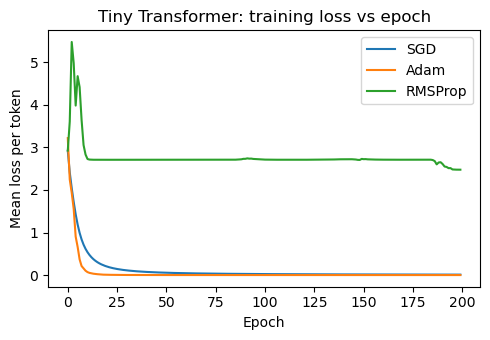

In [10]:
# --------------------------------------------------------------------
# 7. Figure 1: Training loss vs epoch
# --------------------------------------------------------------------
plt.figure(figsize=(5, 3.5))
for name, res in results.items():
    plt.plot(res["loss_history"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Mean loss per token")
plt.title("Tiny Transformer: training loss vs epoch")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("figs/small_transformer_loss_vs_epoch.png", dpi=200, bbox_inches="tight")
print("Saved figs/small_transformer_loss_vs_epoch.png")
plt.show()
plt.close()


## 8. Figure 2 – Final per-position loss

Now we look at *where* in the 5-token window the model finds the
prediction task more or less difficult.

For each optimizer:

* Take the last epoch’s per-position losses
  (mean across all sequences).
* Plot these versus position index (1–5).

The resulting figure is saved as:

* `figs/small_transformer_loss_per_position.png`


Saved figs/small_transformer_loss_per_position.png


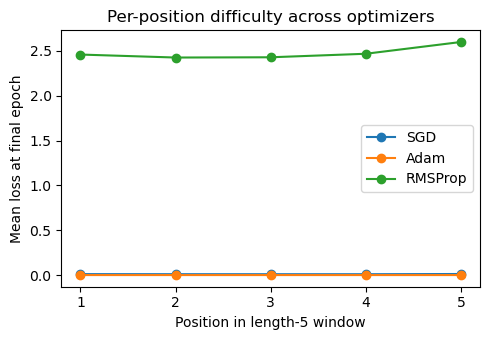

In [11]:
# --------------------------------------------------------------------
# 8. Figure 2: Final per-position loss across the sequence
# --------------------------------------------------------------------
positions = np.arange(1, sequence_length + 1)

plt.figure(figsize=(5, 3.5))
for name, res in results.items():
    final_pos_loss = res["token_loss_history"][-1]  # last epoch, shape (sequence_length,)
    plt.plot(positions, final_pos_loss, marker="o", label=name)
plt.xlabel("Position in length-5 window")
plt.ylabel("Mean loss at final epoch")
plt.title("Per-position difficulty across optimizers")
plt.xticks(positions)
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig("figs/small_transformer_loss_per_position.png", dpi=200, bbox_inches="tight")
print("Saved figs/small_transformer_loss_per_position.png")
plt.show()
plt.close()


## 9. Figure 3 – Confusion matrix for the best optimizer

Finally, we take the optimizer with the **lowest final mean loss**
and inspect its **confusion matrix**:

* Rows = true next characters.
* Columns = predicted characters.
* Entry (i, j) = average predicted probability of character *j*,
  conditioned on true character *i*.

This reveals:

* Strong diagonals → confident, correct predictions.
* Off-diagonal structure → systematic confusions (e.g., space vs period).

The figure is saved as:

* `figs/small_transformer_confusion_matrix.png`



Best optimizer (by final mean loss): Adam
Saved figs/small_transformer_confusion_matrix.png


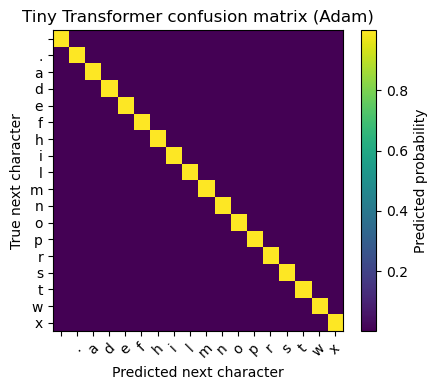

In [12]:
# --------------------------------------------------------------------
# 9. Figure 3: Confusion matrix for best optimizer
# --------------------------------------------------------------------
# Pick optimizer with lowest final mean loss
best_name = min(results.keys(), key=lambda n: results[n]["loss_history"][-1])
best_model = results[best_name]["model"]
print(f"\nBest optimizer (by final mean loss): {best_name}")

def compute_confusion_matrix(model: nn.Module) -> np.ndarray:
    """
    Compute a vocab_size x vocab_size matrix where:
      row = true next character id
      col = predicted next character id
      entry = average predicted probability
    """
    model.eval()
    with torch.no_grad():
        src = X_train.T  # (S, N)
        tgt = Y_train.T  # (S, N)
        logits = model(src, tgt)  # (S, N, vocab_size)

        # reshape to (S*N, vocab_size)
        logits_flat = logits.permute(1, 0, 2).reshape(-1, vocab_size)
        probs_flat = F.softmax(logits_flat, dim=-1)  # (S*N, vocab_size)
        targets_flat = Y_train.reshape(-1)           # (S*N,)

        confusion = torch.zeros(vocab_size, vocab_size, device=device)
        counts = torch.zeros(vocab_size, device=device)

        for p, t in zip(probs_flat, targets_flat):
            confusion[t] += p
            counts[t] += 1.0

        # Avoid division by zero
        counts = counts.clamp_min(1.0)
        confusion = confusion / counts[:, None]

    return confusion.cpu().numpy()

confusion = compute_confusion_matrix(best_model)

plt.figure(figsize=(4.5, 4))
plt.imshow(confusion, aspect="auto")
plt.colorbar(label="Predicted probability")
tick_positions = np.arange(vocab_size)
tick_labels = [idx_to_char[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.yticks(tick_positions, tick_labels)
plt.xlabel("Predicted next character")
plt.ylabel("True next character")
plt.title(f"Tiny Transformer confusion matrix ({best_name})")
plt.tight_layout()

# Save and show
plt.savefig("figs/small_transformer_confusion_matrix.png", dpi=200, bbox_inches="tight")
print("Saved figs/small_transformer_confusion_matrix.png")
plt.show()
plt.close()


## 10. Summary and suggested exercise

This notebook provides all the ingredients for the **Example** in the book:

1. Definition of a tiny Transformer.
2. Qualitative comparison of optimizers via:
   - loss vs epoch (Figure 1),
   - per-position loss (Figure 2),
   - confusion matrix (Figure 3).

A natural **Exercise** is:

> Repeat the analysis for
> 
> * a longer training text (e.g. multiple sentences), and/or  
> * a different window length `sequence_length`.
> 
> Regenerate Figures 1–3 and discuss how the curves and the confusion
> matrices change. Relate your observations to both the optimization
> algorithm and the structure of the data.

For the exercise, the student only needs to:

* change `text` and/or `sequence_length`,
* rerun the notebook,
* compare the new figures under `figs/`.
